In [1]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import sancho
import tadasets
import gudhi as gd
import powerbox as pbox

Modules to reload:
all-except-skipped

Modules to skip:



2023-05-02 15:41:52.023817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


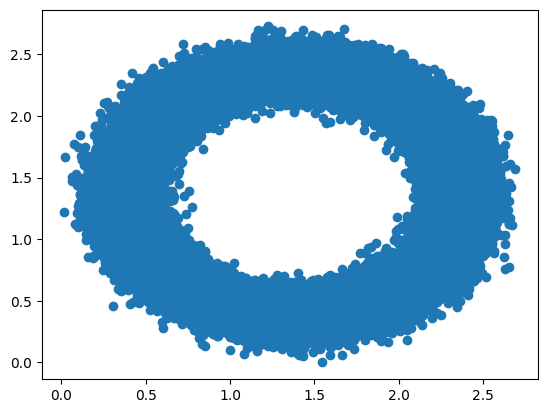

In [96]:
# This is a synthetic data set that we want "approximate"
N = 50000
goal_pts = tadasets.dsphere(n=N, d=1, noise=0.1) # circle
# goal_pts = tadasets.infty_sign(n=N, noise=0.1) # figure eight

# Translate whole point set so that nothing is negative
min_coord = np.min(goal_pts)
goal_pts = goal_pts - min_coord

# Find box_size
box_size = np.max(goal_pts)

# To perform Stochastic Gradient Descent (SGD), we need our set to be of tensor type
goal_pts = torch.tensor(goal_pts)

# Plot the initial/goal data set
P = goal_pts.detach().numpy()
plt.scatter(P[:, 0], P[:, 1])
plt.show()

In [97]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(goal_pts)

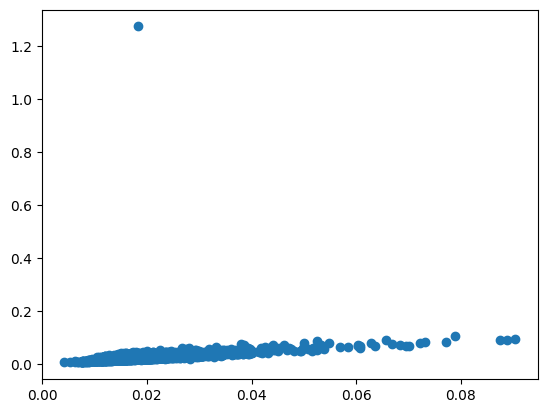

In [88]:
plt.scatter(goal_pd[1][:, 0], goal_pd[1][:, 1])

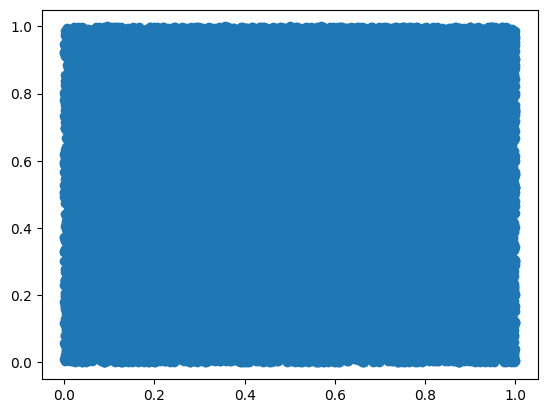

  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [53]:
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, lr=30, dim=2, epochs=300, decay_speed=30, sliced=0.2, filtr="sub_kernel", init_pts="random")

In [98]:
x = torch.tensor([[1,3], [3,4], [5,5], [5,8]])
print(x)

x.sort()
print(x)
kaka, indices = torch.sort(x)

print(kaka)



tensor([[1, 3],
        [3, 4],
        [5, 5],
        [5, 8]])
tensor([[1, 3],
        [3, 4],
        [5, 5],
        [5, 8]])
tensor([[1, 3],
        [3, 4],
        [5, 5],
        [5, 8]])


In [105]:
def tensor_sort(tensor, key_fn):
    # Apply the key function to each element in the tensor
    keys = torch.tensor([key_fn(x) for x in tensor])
    
    # Sort the keys and get the indices
    _, indices = torch.sort(keys)
    
    # Use the sorted indices to sort the original tensor
    sorted_tensor = tensor[indices]
    
    return sorted_tensor

# Example tensor and key function
tensor = torch.tensor([[1.0, 2.0],[ 3.0, 5.0], [5.0, 9.0]])
key_fn = lambda x: x[0] - x[1]

# Sort the tensor using the custom_sort function
sorted_tensor = custom_sort(tensor, key_fn)
print(sorted_tensor)

flatten_tensor = torch.reshape(sorted_tensor, (-1,)).size()
print(len(flatten_tensor))



tensor([[5., 9.],
        [3., 5.],
        [1., 2.]])
1


In [100]:
%timeit sorted_tensor = custom_sort(goal_pd[1], key_fn)

94.6 ms ± 8.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
sorted_kaka = torch.stack(sorted(goal_pd[1], key=lambda diag0: diag0[1] - diag0[0], reverse=True))
print(sorted_kaka)

tensor([[0.0071, 1.0766],
        [0.0398, 0.0993],
        [0.0411, 0.0808],
        ...,
        [0.0256, 0.0149],
        [0.0388, 0.0276],
        [0.0409, 0.0273]], dtype=torch.float64)


In [102]:
%timeit sorted_kaka = torch.stack(sorted(goal_pd[1], key=lambda diag0: diag0[0] - diag0[1]))

438 ms ± 9.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
sorted_kaka

tensor([[0.0071, 1.0766],
        [0.0398, 0.0993],
        [0.0411, 0.0808],
        ...,
        [0.0256, 0.0149],
        [0.0388, 0.0276],
        [0.0409, 0.0273]], dtype=torch.float64)

In [107]:
sorted_kaka[0] = sorted_kaka[0] - 1

In [108]:
sorted_kaka

tensor([[-0.9929,  0.0766],
        [ 0.0398,  0.0993],
        [ 0.0411,  0.0808],
        ...,
        [ 0.0256,  0.0149],
        [ 0.0388,  0.0276],
        [ 0.0409,  0.0273]], dtype=torch.float64)

In [2]:
pts = tadasets.sphere(n=50000, r=1, noise=0.4)
X = torch.tensor(pts)

pd = gen_data.create_hybrid_dtm_pd(X)

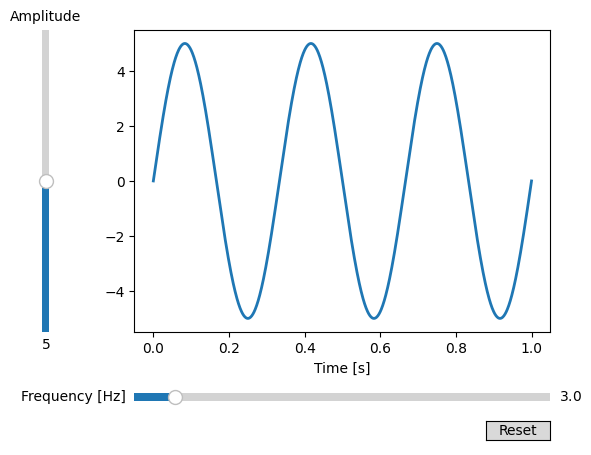

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()